<a href="https://colab.research.google.com/github/mars241/WebScraping/blob/main/AAM_WCS_API_REST_Faire_une_requ%C3%AAte_depuis_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦾Challenge
Récupère les données depuis l'API REST suivante.

La documentation de l'API est [disponible ici](https://data.nantesmetropole.fr/explore/dataset/244400404_stations-velos-libre-service-nantes-metropole-disponibilites/api/).

Affiche un DataFrame avec l'adresse de chaque station, et le taux de remplissage associé (c'est-à-dire le nombre de vélos disponibles available_bikes / le nombre d'emplacement total bike_stands).

Résultat attendu (les taux de remplissage seront différents, car les données sont générées en temps réel) :
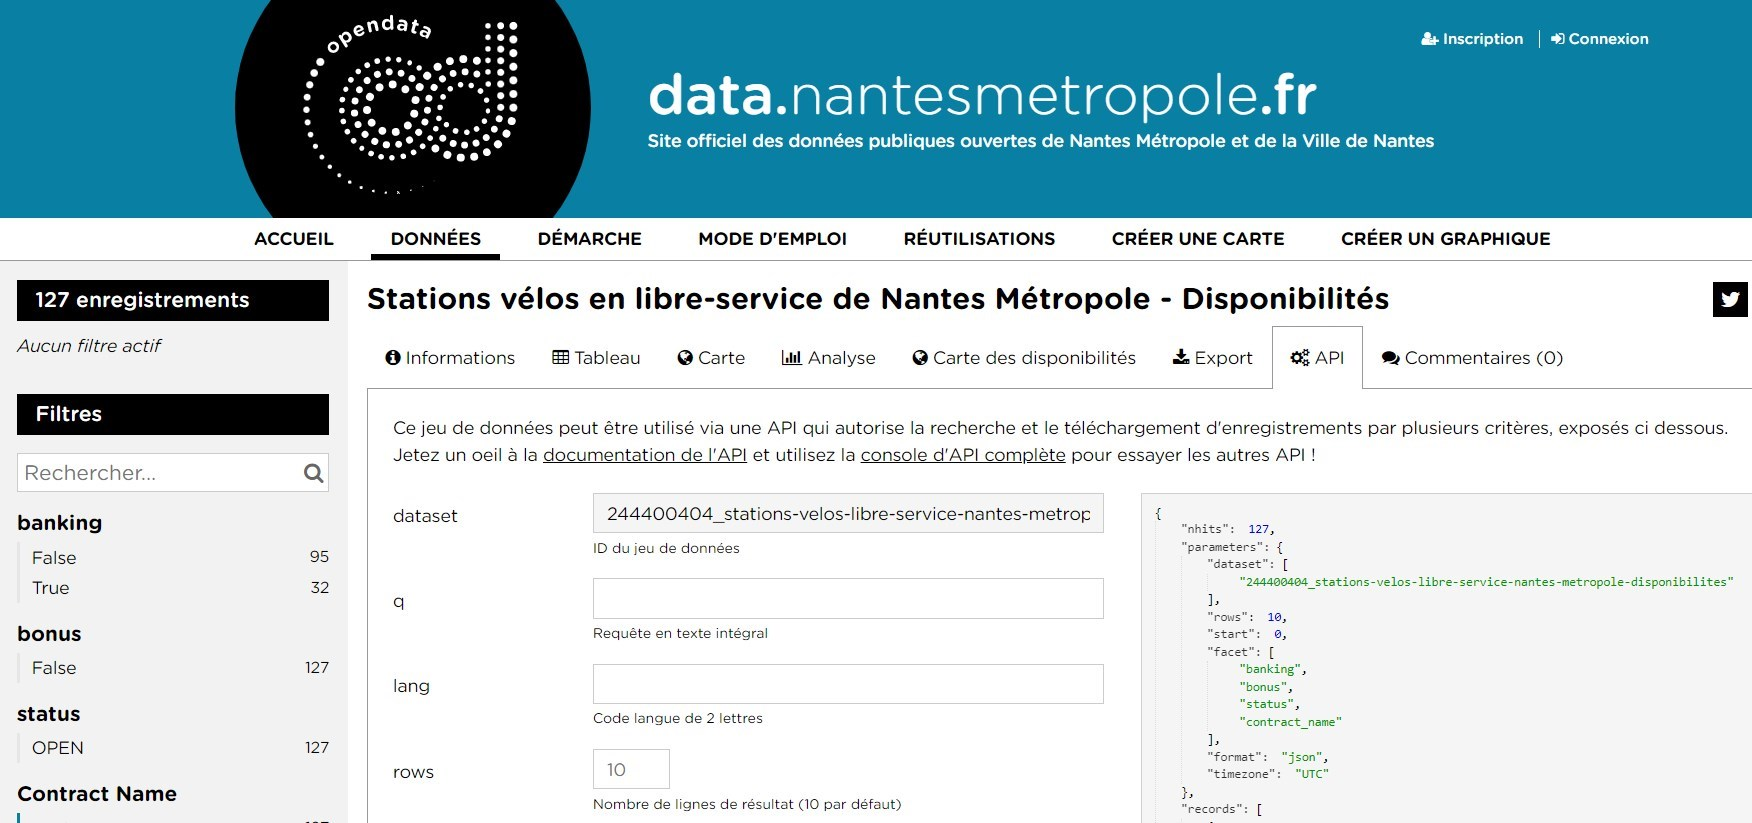


In [ ]:
import json
import requests
import pandas as pd

link = "https://data.nantesmetropole.fr/api/records/1.0/search/?dataset=244400404_stations-velos-libre-service-nantes-metropole-disponibilites&q=&facet=banking&facet=bonus&facet=status&facet=contract_name"

# Cette fonction "requests.get(URL)" récupère le contenu du fichier à partir de l'URL
read = requests.get(link)

# Accéder au contenu du texte avec cette fonction:
read.text

data = json.loads( read.text)
data

{'nhits': 127,
 'parameters': {'dataset': ['244400404_stations-velos-libre-service-nantes-metropole-disponibilites'],
  'rows': 10,
  'start': 0,
  'facet': ['banking', 'bonus', 'status', 'contract_name'],
  'format': 'json',
  'timezone': 'UTC'},
 'records': [{'datasetid': '244400404_stations-velos-libre-service-nantes-metropole-disponibilites',
   'recordid': '3af0e63d86ad725ac6beb241eb0db5730f8dbf53',
   'fields': {'available_bike_stands': 12,
    'bike_stands': 15,
    'number': 117,
    'address': 'Place de la Liberté',
    'name': '117-MAIRIE DE CHANTENAY',
    'bonus': 'False',
    'banking': 'False',
    'contract_name': 'nantes',
    'status': 'OPEN',
    'available_bikes': 3,
    'position': [47.20656, -1.58785],
    'last_update': '2023-03-30T12:02:15+00:00'},
   'geometry': {'type': 'Point', 'coordinates': [-1.58785, 47.20656]}},
  {'datasetid': '244400404_stations-velos-libre-service-nantes-metropole-disponibilites',
   'recordid': '9874eceb4ae4c0482fa4d881483dd9e55410f0e4

In [ ]:
# Cette fonction "requests.get(URL)" affiche aussi la réponse de la requête si elle a bien fonctionné(<Response [200]> :communication établie, prêt à WebScrapper!)
read = requests.get(link)
# Affichage de

read

<Response [200]>

In [ ]:
# Vérification des catégories de premier niveau sur lesquelles On peut "fouiller"

for i in read.json():
  print(i)

nhits
parameters
records
facet_groups


In [ ]:
# Vue que nous voulons des données concernat l'activité de parc vélos, "records" contient surement des informations intéressantes !

for i in read.json()["records"]:
  print(i)

{'datasetid': '244400404_stations-velos-libre-service-nantes-metropole-disponibilites', 'recordid': 'b9c525140686b39745666bbe41512644570a8a72', 'fields': {'available_bike_stands': 0, 'bike_stands': 0, 'number': 1011, 'address': 'Borne test 1', 'name': '01011 - BORNE TEST NANTES 1', 'bonus': 'False', 'banking': 'False', 'contract_name': 'nantes', 'status': 'OPEN', 'available_bikes': 0, 'position': [47.19504, -1.5575], 'last_update': '2022-05-23T14:41:50+00:00'}, 'geometry': {'type': 'Point', 'coordinates': [-1.5575, 47.19504]}}
{'datasetid': '244400404_stations-velos-libre-service-nantes-metropole-disponibilites', 'recordid': '382ee2b083264e50cbc32e0edbd93de920f4bbbd', 'fields': {'available_bike_stands': 6, 'bike_stands': 7, 'number': 1012, 'address': 'CREATION STATION TEST NANTES 2', 'name': '01012 - BORNE TEST NANTES 2', 'bonus': 'False', 'banking': 'False', 'contract_name': 'nantes', 'status': 'OPEN', 'available_bikes': 0, 'position': [47.195299, -1.557559], 'last_update': '2023-03-2

In [ ]:
# Création d'un nouveau dataset pour accèder à un niveau hiérachique plus bas voulu (ici "records") du fichier JSON avec la fonction "json_normalize"
newdata = pd.json_normalize(data,record_path="records")

# Renommer le Dataset et les colonnes cibles
df = pd.DataFrame(newdata)
df = df.rename(columns={'fields.address': 'Adresse'})

# Accès et sélection de toutes les lignes des 3 colonnes choisies du dataset
df = df.loc[:,["Adresse","fields.available_bike_stands","fields.bike_stands"]]

# Création et aggrégation(quotient) de 2 colonnes
df["taux_remplissage"]=df['fields.available_bike_stands']/df['fields.bike_stands']

# Sélection de toute les lignes des colonnes (renommée & aggrégée) du dataset
df = df.loc[:,["Adresse","taux_remplissage"]]
df

,Adresse,taux_remplissage
0,"15, rue de Verdun",1.000000
1,"4, place Sainte Elisabeth",0.857143
2,"1, boulevard Allard - Place Général Mellinet",0.866667
3,Place de la Liberté,0.800000
4,"42, boulevard Gabriel Guist'Hau",0.133333
5,Place Foch,0.714286
6,"18, rue du Moulin",0.800000
7,"15, quai de Malakoff",0.400000
8,Angle boulevard Gaston Serpette - Boulevard Au...,0.866667
9,"1, allée de l'Île Gloriette",0.259259


In [ ]:
# Autrement(mieux)
# Le " Taux de remplissage " doit être en %,La prise en compte qu'une station puisse être vide en remplaçant les NaN par 0, puis on fait ressembler la valeur à un taux
df["taux_remplissage_en%"] = (df['fields.available_bike_stands']/df['fields.bike_stands']).apply(lambda x: f"{round(x * 100)} %")

# On garde la sélection finale avec un petit tri pour plus remplies en premier
df[["Adresse", "taux_remplissage_en%"]].sort_values(by = "taux_remplissage_en%", ascending = False)